### Univariate analyses for Prisma
#### novel vs. repeated scenes task, second-level univariate contrast maps and tSNR calculations
#### testing week of 8/14

1. import packages and functions (note: slice/glm specifically designed for MNI, adapted slice/glm_t1w for native)

In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from slice import glm
from slice import glm_t1w
from nilearn.image import load_img, concat_imgs, mean_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_design_matrix
import warnings
from pathlib import Path
import json
import numpy as np
import pandas as pd
import nibabel as nib
import mindstorm.glm as mglm
import nilearn.image
from nilearn.maskers import NiftiMasker
from nilearn.masking import apply_mask
import scipy.stats as stats

warnings.filterwarnings("ignore", 'Mean values of 0 observed.')
warnings.filterwarnings("ignore", "invalid value encountered in true_divide")


2. Define paths and parameters
* currently set up for local machine, can modify paths as needed
* formatted event files should be in rawdata directory, must be named with BIDS convention, just like scans
* make sure subject and task appear exactly as appear in file names based on BIDS conventions

In [2]:
data_dir = Path("/Users/owenfriend/Documents/temple_local/prisma_ANALYSIS/rawdata")
fmriprep_dir = Path("/Users/owenfriend/Documents/temple_local/prisma_ANALYSIS/derivatives/fmriprep-23.0.2")
out_path = Path("/Users/owenfriend/Documents/temple_local/prisma_ANALYSIS/derivatives/output")

subject = "temple024"
task = "arrow"
n_run = 2
space = "T1w"
confound_measures = [
    "trans_x", 
    "trans_x_derivative1", 
    "trans_y", 
    "trans_y_derivative1", 
    "trans_z", 
    "trans_z_derivative1", 
    "rot_x", 
    "rot_x_derivative1", 
    "rot_y", 
    "rot_y_derivative1", 
    "rot_z", 
    "rot_z_derivative1",
    "csf",
    "csf_derivative1",
    "white_matter",
    "white_matter_derivative1",
]

3. Define mask image within which you'll be modeling activity
* use full file path, should be in anat folder of fmriprep directory

In [3]:
mask_file = '/Users/owenfriend/Documents/temple_local/analysis/data/derivatives/fmriprep-23.0.2/sub-temple024/anat/sub-temple024_space-T1w_label-gray_mask.nii.gz'
mask_img = nib.load(mask_file)


4. Load in scan files and generate design matrix
* run design matrix and functional timeseries will be appended to lists which can then be referenced for 1st level analyses
* run_mask_img defaults to space-T1w_desc-brain_mask.nii.gz from fmriprep output
* will print update for each run modeled to make sure both are done

In [15]:
run_design = []
run_data = []
run_mask_img = []
for run in range(1, n_run + 1):
    print('running run ' + str(run))
    design, data, mask_img = prep_run_model_T1w(
        data_dir, 
        fmriprep_dir, 
        subject, 
        task, 
        run, 
        space,
        confound_measures, 
    )
    run_design.append(design)
    run_data.append(data)
    run_mask_img.append(mask_img)

running run 1
running run 2


<AxesSubplot:label='conditions', ylabel='scan number'>

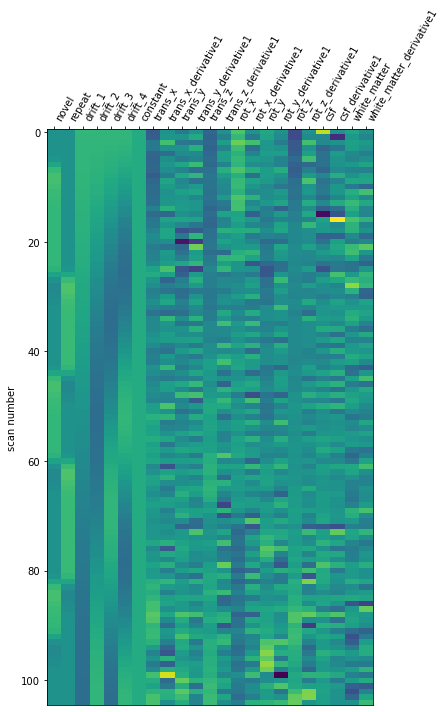

In [16]:
# visualize design matrix
plot_design_matrix(run_design[0])

5. Create first level model for each run with data and design matrix from that run

In [17]:
fmri_glm_1 = FirstLevelModel(mask_img=mask_img, minimize_memory=False)
glm_res_1 = fmri_glm_1.fit(run_data[0], design_matrices=run_design[0])

fmri_glm_2 = FirstLevelModel(mask_img=mask_img, minimize_memory=False)
glm_res_2 = fmri_glm_2.fit(run_data[1], design_matrices=run_design[1])

6. compute t maps for each run based on novel-repeated contrast

In [19]:
contrast = 'novel - repeat'

# generate t map for run 1
t_map_1 = fmri_glm_1.compute_contrast(contrast, output_type="stat")


# generate t map for run 2
t_map_2 = fmri_glm_2.compute_contrast(contrast, output_type="stat")

# combine t maps
t_maps = [t_map_1, t_map_2]

7. Create simple design matrix for two t maps from different runs

In [20]:
# design matrix to combine two t maps for second level analysis

second_level_input = t_maps
design_matrix = pd.DataFrame(
    [1] * len(second_level_input),
    columns=["category"],
)

8. Fit second level model combining t maps from two runs

In [32]:
# fit second level model

second_level_model = SecondLevelModel(minimize_memory = False)
second_level_model = second_level_model.fit(
    second_level_input,
    design_matrix=design_matrix,
)

9. Output maps and statistics

In [33]:
contrast_name = 'novelty_contrast'
# output z map
z_map = second_level_model.compute_contrast(second_level_contrast="category", output_type="z_score")
nib.save(z_map, out_path / f"sub-{subject}_contrast-{contrast_name}_ZMAP.nii.gz")


# output t map
t_map = second_level_model.compute_contrast(second_level_contrast="category", output_type="z_score")
#nib.save(t_map, out_path / f"sub-{subject}_contrast-{contrast_name}_TMAP.nii.gz")

# output beta map
beta_map = second_level_model.compute_contrast(second_level_contrast="category", output_type="effect_size")
#nib.save(beta_map, out_path / f"sub-{subject}_contrast-{contrast_name}_betaMAP.nii.gz")

# output cohen's d map
var = second_level_model.compute_contrast(second_level_contrast="category", output_type="effect_variance")
d = beta_map.get_fdata() / np.sqrt(var.get_fdata())
d_img = nib.Nifti1Image(d, mask_img.affine, mask_img.header)
#nib.save(d_img, out_path / f"sub-{subject}_contrast-{contrast_name}_dMAP.nii.gz")

10. Compute total number of voxels at given activity levels

In [34]:
# create df with voxels at given z scores
activity = z_map.get_fdata()
flattened_data = activity.ravel()
results_df = pd.DataFrame(columns = ['Activity Level (z)', 'Voxel Count'])

activity_levels = []
for i in np.arange(-5, 5, 0.5):
    activity_levels.append([i, i+1])
    
for level in activity_levels:
        # Count voxels within the given activity level range
        voxel_count = len(flattened_data[(flattened_data >= level[0]) & (flattened_data <= level[1])])
        
        # Add the result to the DataFrame
        results = results_df.loc[len(results_df)] = [level, voxel_count]

In [35]:
results_df

,Activity Level (z),Voxel Count
0,"[-5.0, -4.0]",14
1,"[-4.5, -3.5]",68
2,"[-4.0, -3.0]",400
3,"[-3.5, -2.5]",1816
4,"[-3.0, -2.0]",6429
5,"[-2.5, -1.5]",18193
6,"[-2.0, -1.0]",40832
7,"[-1.5, -0.5]",72548
8,"[-1.0, 0.0]",517642
9,"[-0.5, 0.5]",527000


11. Calculate temporal signal to noice - REQUIRES ROI MASK

In [36]:
# EXAMPLE of extracting mask from freesurfer output using freesurfer atlas values

# extract binary mask from freesurfer output
seg_file = (
    fmriprep_dir 
    / f"sub-{subject}"
    / "func" 
    / f"sub-{subject}_task-{task}_run-1_space-{space}_desc-aparcaseg_dseg.nii.gz"
)
img = nib.load(seg_file)
seg = img.get_fdata()

gm_mask = (
    ((1000 <= seg) & (seg <= 1035))
    | ((2000 <= seg) & (seg <= 2035))
    | ((9 <= seg) & (seg <= 13))
    | ((17 <= seg) & (seg <= 18))
    | ((48 <= seg) & (seg <= 54))
)



In [44]:
# need to input roi mask first
roi_mask = 

# TSNR
tsnr = []
#tsnrn = []

# temporal signal-to-noise ratio, with SD estimated on residuals

for bold, pred in zip(run_data, fmri_glm_1.predicted):
    y = bold.get_fdata()
    y_hat = pred.get_fdata()
    #resid = y - y_hat
    
    m = np.mean(y, axis=3)
    sd = np.std(y, axis=3)
    #sd_n = np.std(resid, axis=3)
    
    run_tsnr = m / sd
    #run_tsnrn = m / sd_n
    tsnr.append(run_tsnr)
    #tsnrn.append(run_tsnrn)
    
# save tSNR image
mean_tsnr = np.mean(np.stack(tsnr, axis=3), axis=3)
mean_tsnr[~roi_mask] = 0
new_img = nib.Nifti1Image(mean_tsnr, mask_img.affine, mask_img.header)

roi_tsnr = np.nanmean(mean_tsnr[roi_mask])
nib.save(new_img, out_path / f"sub-{subject}_tsnr.nii.gz")

In [45]:
roi_tsnr

42.45880310670232

In [ ]:
# save tSNRn image --?
mean_tsnrn = np.mean(np.stack(tsnrn, axis=3), axis=3)
mean_tsnrn[~roi_mask] = 0
new_img = nib.Nifti1Image(mean_tsnrn, mask_vol.affine, mask_vol.header)
nib.save(new_img, out_path / f"sub-{subject}_tsnrn.nii.gz")

In [5]:
def prep_run_model_T1w(
    data_dir,
    fmriprep_dir,
    subject,
    task,
    run,
    space,
    confound_measures,
    events_column="category",
    offset=None,
):
    """Prepare data and model for fitting one run."""
    # task events, functional data, and confounds
    data_dir = Path(data_dir)
    fmriprep_dir = Path(fmriprep_dir)
    events_path = (
        data_dir
        / f"sub-{subject}"
        / "func"
        / f"sub-{subject}_task-{task}_run-{run}_events.tsv"
    )
    func_path = (
        fmriprep_dir
        / f"sub-{subject}"
        / "func"
        / f"sub-{subject}_task-{task}_run-{run}_space-{space}_desc-preproc_bold.nii.gz"
    )
    confound_path = (
        fmriprep_dir
        / f"sub-{subject}"
        / "func"
        / f"sub-{subject}_task-{task}_run-{run}_desc-confounds_timeseries.tsv"
    )
    mask_path = (
        fmriprep_dir
        / f"sub-{subject}"
        / "func"
        / f"sub-{subject}_task-{task}_run-{run}_space-T1w_desc-brain_mask.nii.gz"
    )

    # load functional timeseries information
    func_json = func_path.with_suffix("").with_suffix(".json")
    with open(func_json, "r") as f:
        func_param = json.load(f)
    tr = func_param["RepetitionTime"]
    time_offset = func_param["StartTime"]

    # create nuisance regressor matrix
    confounds = pd.read_table(confound_path)
    nuisance, nuisance_names = mglm.create_confound_matrix(
        confounds, confound_measures, censor_motion=True
    )

    # make design matrix
    events = pd.read_table(events_path)
    if offset is not None:
        events["onset"] += offset
    img = nib.load(func_path)
    n_vol = img.header["dim"][4]
    design = mglm.create_simple_design(
        events, events_column, n_vol, tr, time_offset, high_pass=0.01
    )

    # add confounds
    full_design = pd.DataFrame(
        np.hstack([design.to_numpy(), nuisance]),
        index=design.index,
        columns=design.columns.to_list() + nuisance_names,
    )

    # load functional data
    bold_vol = nib.load(func_path)
    mask_vol = nib.load(mask_path)
    return full_design, bold_vol, mask_vol


### reformat temple data for testing (move to bottom)

In [577]:
# add binary category to temple data
for run in (1, n_run):
    t = pd.read_table('/Users/owenfriend/Documents/temple_local/analysis/data/rawdata/sub-temple024/func/sub-temple024_task-arrow_run-' + str(run) + '_events.tsv')
    t = t.dropna().reset_index().iloc[:, 1:]
    t.insert(9, 'category', 0, True)
    for index, row in t.iterrows():
        if t['object'][index] < 29:
            t.at[index, 'category'] = 'low'
        else:
            t.at[index, 'category'] = 'high'
    
    
    #t.to_csv('/Users/owenfriend/Documents/temple_local/analysis/data/rawdata/sub-temple024/func/sub-temple024_task-arrow_run-' + str(run) + '_events.tsv', sep="\t")

In [578]:
for index in range(36):
    if index < 8:
        t.at[index, 'category'] = 'novel'
        #t.at[index, 'category'] = 1
    elif (index > 7) & (index < 16):
        t.at[index, 'category'] = 'repeat'
        #t.at[index, 'category'] = 2
    elif (index > 15) & (index < 24):
        t.at[index, 'category'] = 'novel'
        #t.at[index, 'category'] = 3
    elif (index > 23) & (index < 32):
        t.at[index, 'category'] = 'repeat'
        #t.at[index, 'category'] = 4
    else:
        t.at[index, 'category'] = 'novel'
        #t.at[index, 'category'] = 5